# Load package and example data

After importing the packages, we use the ``torch.set_default_tensor_type`` function to enable GPU acceleration if CUDA is available.

In [1]:
from iPoLNG import iPoLNG
import torch
import scanpy as sc
import matplotlib.pyplot as plt
torch.set_default_tensor_type("torch.cuda.FloatTensor" if torch.cuda.is_available() else "torch.FloatTensor")

Next, we load the example data attached in the ``iPoLNG`` package. The example data has two data modalities: ``W1`` has 500 cells and 5,000 features, ``W2`` has 500 cells and 20,000 features. Note that these 500 cells should be matched accordingly across different data modalities.

In [2]:
W = iPoLNG.load_example_data()
print(W.keys())
print(W['W1'].shape)
print(W['W2'].shape)

dict_keys(['W1', 'W2'])
torch.Size([500, 5000])
torch.Size([500, 20000])


# Run the iPoLNG model

Now we are ready to run the model. The parameters are set in the ``iPoLNG.iPoLNG`` function, and ``model.Run()`` will start the computation.

In [4]:
model = iPoLNG.iPoLNG(W, num_topics=20, integrated_epochs=300, warmup_epochs=500, seed=42, verbose=True)
result = model.Run()

Run PoLNG for data modality W1 ...


100%|██████████| 500/500 [00:08<00:00, 60.69it/s, epoch_loss=1.82e+03]


Run PoLNG for data modality W2 ...


100%|██████████| 500/500 [00:30<00:00, 16.44it/s, epoch_loss=5.73e+03]


alpha0 for data modality W1: 5.843589597346264
alpha0 for data modality W2: 7.599075458477387
Run iPoLNG...


100%|██████████| 300/300 [00:31<00:00,  9.61it/s, epoch_loss=7.33e+03]


# Analyze the result

Let's see the structure of ``result``.

In [5]:
result.keys()

dict_keys(['L_est', 'Ls_est', 'Thetas_est', 'time', 'loss', 'alpha0s'])

In [6]:
result['L_est'].shape

(500, 20)

We use ``scanpy`` package to perform leiden clustering and plot the heatmap.

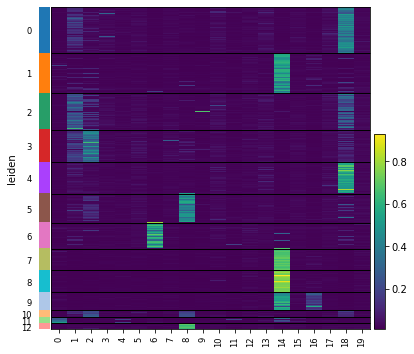

In [7]:
adata = sc.AnnData(result['L_est'])
sc.pp.neighbors(adata, n_neighbors=15,use_rep='X')
sc.tl.leiden(adata)
L_est_reorder = result['L_est'][adata.obs['leiden'].sort_values().index.to_numpy(dtype=int),:]
sc.pl.heatmap(adata,var_names=adata.var_names,groupby='leiden')

In [8]:
print(result['Ls_est'].keys())
print(result['Ls_est']['W1'].shape)
print(result['Ls_est']['W2'].shape)

dict_keys(['W1', 'W2'])
(500, 20)
(500, 20)


In [9]:
print(result['Thetas_est'].keys())
print(result['Thetas_est']['W1'].shape)
print(result['Thetas_est']['W2'].shape)

dict_keys(['W1', 'W2'])
(20, 5000)
(20, 20000)


In [10]:
print("The running time of the program is {}s.".format(result['time']))

The running time of the program is 69.95521092414856s.


We plot the ``loss`` (negative ELBO) for PoLNG in the warm-up step and iPoLNG. We can see that the loss decreases quickly in the first few epochs, which suggests that the stochastic variational inference algorithm is effective.

dict_keys(['W1', 'W2', 'iPoLNG'])


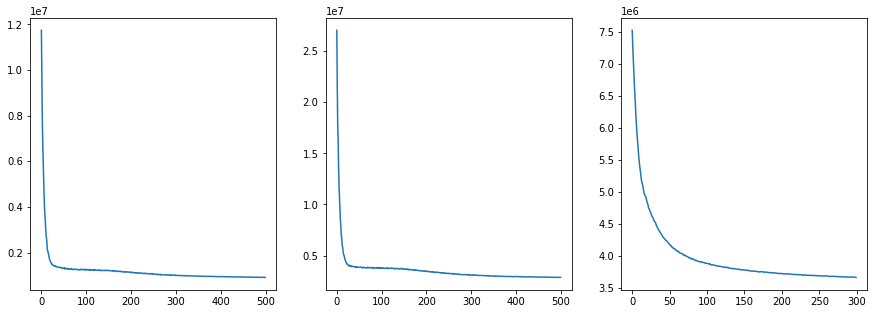

In [11]:
print(result['loss'].keys())
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(result['loss']['W1'])
axes[1].plot(result['loss']['W2'])
axes[2].plot(result['loss']['iPoLNG'])

``alpha0s`` saves the hyperparameters that controls the noise of level in different data modalities.

In [12]:
result['alpha0s']

{'W1': 5.843589597346264, 'W2': 7.599075458477387}